In [2]:
mutable struct Nodes
    parent::Array{Int}
    size::Array{Int}
    num_components::Int
    
    function Nodes(size)
        new(Array(collect(1:size)), zeros(Int, size), size)
    end
end

In [3]:
function findroot(cluster::Nodes, i)
    root = i
    while root != cluster.parent[root]
        root = cluster.parent[root]
    end
    
    #
    # Path Compression
    #
    while i != root
        next = cluster.parent[i]
        cluster.parent[i] = root
        i = next
    end
    return root
end

function unionfind!(cluster::Nodes, i, j)
    rooti = findroot(cluster, i)
    rootj = findroot(cluster, j)
    if rootj != rooti
        if cluster.size[rooti] > cluster.size[rootj]
            cluster.parent[rootj] = rooti
            cluster.size[rooti] += cluster.size[rootj]
        else
            cluster.parent[rooti] = rootj
            cluster.size[rootj] += cluster.size[rooti]
        end
        cluster.num_components -= 1
    end
end

function connected(cluster::Nodes, i, j)
    return findroot(cluster, i) == findroot(cluster, j)
end

function components(cluster::Nodes)
    return cluster.num_components
end

components (generic function with 1 method)

In [4]:
cluster = Nodes(10)

Nodes([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10)

In [5]:
unionfind!(cluster, 1, 2)
cluster

Nodes([2, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9)

In [6]:
unionfind!(cluster, 2, 3)
cluster

Nodes([2, 3, 3, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 8)

In [7]:
unionfind!(cluster, 3, 4)
cluster

Nodes([2, 3, 4, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7)

In [8]:
connected(cluster, 1, 5)

false

# Graph 

In [9]:
using LightGraphs
using GraphIO
using Random
using DataFrames
using Statistics
using Plots

In [10]:
g = loadgraph("data/iceland.lnk", GraphIO.EdgeList.EdgeListFormat())
g = SimpleGraph(g)

{75, 114} undirected simple Int64 graph

In [32]:
function site_percolation(g)
    N = nv(g)
    result = ones(Int, N)

    # collect and shuffle the nodes id 
    vertice_set = collect(vertices(g));
    shuffle!(vertice_set);

    nodes = Nodes(N)
    
    for (i,v) in enumerate(vertice_set)
        nodes.size[v] = 1 # activate the site v
        for neighbor in outneighbors(g,v)
            if nodes.size[neighbor] > 0 # check if the site has already been activated
                unionfind!(nodes, v, neighbor)
            end
        end
        result[i] += maximum(nodes.size)
    end
    return result
end

function bond_percolation(g)
    N = nv(g)
    result = ones(Int, ne(g))
    
    # collect and shuffle the edges 
    edges_set = collect(edges(g));
    shuffle!(edges_set);

    nodes = Nodes(N)
    nodes.size = ones(N)
    
    for (i,e) in enumerate(edges_set)
        unionfind!(nodes, src(e), dst(e))
        result[i] += maximum(nodes.size)
    end
    return result
end

bond_percolation (generic function with 1 method)

In [33]:
num_simulation = 1000
result = zeros(Int, nv(g))

for _ in 1:num_simulation
    result += site_percolation(g)
end

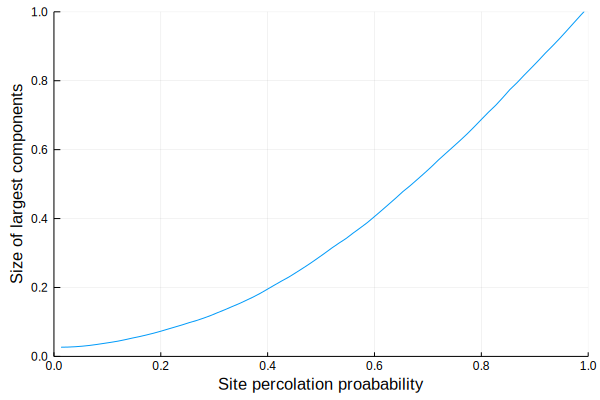

In [34]:
p = collect(1:nv(g)) / nv(g)
CC = result / (num_simulation * nv(g))

plot(p, CC, ylabel="Size of largest components", xlabel="Site percolation proabability", leg=false)
ylims!(0.0, 1.0)
xlims!(0.0, 1.0)

In [39]:
num_simulation = 1000
result = zeros(Int, ne(g))

for _ in 1:num_simulation
    result += bond_percolation(g)
end

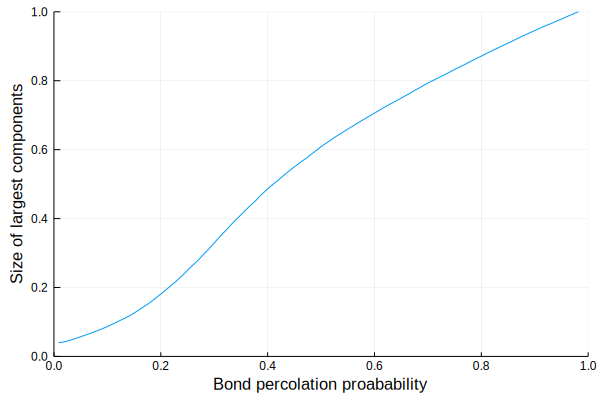

In [45]:
p = collect(1:ne(g)) / ne(g)
CC = result / (num_simulation * nv(g))

plot(p, CC, ylabel="Size of largest components", xlabel="Bond percolation proabability", leg=false)
ylims!(0.0, 1.0)
xlims!(0.0, 1.0)